# **Limpieza de datos**

En este notebook se mostrarán los pasos seguidos para la limpieza de datos. Dentro de las cosas que se mostrarán será la eliminación de las columnas de datos que no se utilizaran, la limpieza de valores de las columnas que permanecerán (eliminar o cambiar valores nulos) y la creación de nuevas columnas que puedan permitir un análisis más profundo de los datos.

## **Importar las librerias y los datos**
Importamos las librerías de pandas, matplotlib y seaborn. Además, definimos las variables para poner la url de los archivos csv.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
train_url = "https://drive.google.com/file/d/1uRFP0zYKdnOQ1EwF1SbvSTHqH9ptZzom/view?usp=sharing"
test_url = "https://drive.google.com/file/d/1v0SwbZ4fa55Qpx9ax-k-iNhgu3jdNXJJ/view?usp=sharing"

In [ ]:
path = 'https://drive.google.com/uc?export=download&id='+train_url.split('/')[-2]
train = pd.read_csv(path)

path = 'https://drive.google.com/uc?export=download&id='+test_url.split('/')[-2]
test = pd.read_csv(path)

Una vez que los datos estan cargados, podemos comprobar cuantos valores nulos se encuentran en los archivos de train y test.

In [ ]:
train.isnull().sum()
#faltan 177 en edad, esta variable es importante se tiene que buscar tecnica para llenar
#faltan 687 valores en cabina, es mas del 60% de la variable, se puede eliminar
#faltan 2 en puerto de embarque, son muy pocos se pueden eliminar

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [ ]:
test.isnull().sum()
#faltan 86 en edad, esta variable es importante se tiene que buscar tecnica para llenar
#faltan 1 en precio, son muy pocos se pueden eliminar
#faltan 327 valoren en cabina, es mas del 60% de la variable, se puede eliminar

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

## **Limpieza de los datos**
Una vez que ya se decidieron las columnas que se van a utilizar, podemos comenzar a limpiar los datos. En el read.me se puede encontrar más información de las columnas que se mantienen.

Primero, creamos una columna con los titulos que tiene cada pasajero. A pesar de que existen muchos titulos en todos los pasajeros, los podemos mapear en 6 categorías: Officer, royal, mrs, mr, miss y master.

Esta información la guardamos en una nueva columna llamada Title.

In [ ]:
train['Title'] = train.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip())
test['Title'] = test.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip())

mapa_titulos = {
    "Capt":       "Officer",
    "Col":        "Officer",
    "Major":      "Officer",
    "Jonkheer":   "Royal",
    "Don":        "Royal",
    "Sir" :       "Royal",
    "Dr":         "Officer",
    "Rev":        "Officer",
    "the Countess":"Royal",
    "Dona":       "Royal",
    "Mme":        "Mrs",
    "Mlle":       "Miss",
    "Ms":         "Mrs",
    "Mr" :        "Mr",
    "Mrs" :       "Mrs",
    "Miss" :      "Miss",
    "Master" :    "Master",
    "Lady" :      "Royal"
}

train.Title = train.Title.map(mapa_titulos)
test.Title = test.Title.map(mapa_titulos)

print(train.Title.unique())
print(test.Title.unique())

['Mr' 'Mrs' 'Miss' 'Master' 'Royal' 'Officer']
['Mr' 'Mrs' 'Miss' 'Master' 'Officer' 'Royal']


Eliminamos las columnas de PassengerID, Ticket, Cabin y Name de los dos sets de datos que tenemos.

In [ ]:
train.drop(columns=["PassengerId", "Ticket", "Cabin", "Name"], inplace=True)
test.drop(columns=["PassengerId", "Ticket", "Cabin", "Name"], inplace=True)

Eliminamos los registros que son nulos en la columna de embarked y de fare, debido a que son muy pocos registros.

In [ ]:
train.dropna(subset=['Embarked'],inplace=True)
test.dropna(subset=['Fare'],inplace=True)

Debido a que existen muchos registros que no cuentan con la edad, podemos estimarla tomando en cuenta la clase en la que viaja el pasajero, su titulo y su sexo. Para calcularla utilizamos el promedio de la edad de otras personas que tienen su mismo sexo, clase y título.

In [ ]:
train_age_map = train.groupby(['Title', 'Pclass', 'Sex'])['Age'].transform('mean') #Calculamos la media de edad por las características
train['Age'].fillna(train_age_map, inplace=True) #Asignamos las edades

test_age_map = test.groupby(['Title', 'Pclass', 'Sex'])['Age'].transform('mean') #Calculamos la media de edad por las características
test['Age'].fillna(train_age_map, inplace=True) #Asignamos las edades

La variable de sexo es cualitativa, por lo que viene definida como string. Sabemos que solamente puede tomar el valor de male y female. Por esto, la podemos convertir a numeros para el procesamiento, asignando un 0 a los valores de femenino y un 1 a los valores de masculino.

In [ ]:
train['Sex'] = train['Sex'].map({'female': 0, 'male': 1})
test['Sex'] = test['Sex'].map({'female': 0, 'male': 1})

Tenemos otras variables cualitativas dentro de los datasets. Por esto, se usa la estrategia de **one hot encoding** para generar las columnas de donde embarcaron y su titulo.

Utilizamos esta tecnica en lugar de solamente cambiar los valores por 1, 2, 3, etc, porque el hecho de que un lugar de embarcación sea 1 y el otro 3, el modelo lo puede confundir con que uno es tres veces mas que el otro. Por lo tanto, esta estrategia nos crea una nueva columna con cada valor que se puede tener. Por ejemplo, embarked_C, embarked_S, etc. Y solo los registros que hayan embarcado en "C" tendrán un 1 en la columna de embarked_C, mientras que los demás tendrán un 0.



In [ ]:
#Creamos las nuevas columnas para el set de train
embarked_dummies = pd.get_dummies(train['Embarked'], prefix='Embarked')
train = pd.concat([train, embarked_dummies], axis=1)
train.drop('Embarked', axis=1, inplace=True) #Eliminamos la columna anterior porque ya no es necesaria.

title_dummies = pd.get_dummies(train['Title'], prefix='Title')
train = pd.concat([train, title_dummies], axis=1)
train.drop('Title', axis=1, inplace=True)


#Creamos las nuevas columnas para el set de test
embarked_dummies = pd.get_dummies(test['Embarked'], prefix='Embarked')
test = pd.concat([test, embarked_dummies], axis=1)
test.drop('Embarked', axis=1, inplace=True)

title_dummies = pd.get_dummies(test['Title'], prefix='Title')
test = pd.concat([test, title_dummies], axis=1)
test.drop('Title', axis=1, inplace=True)

A continuación, se muestran graficas con algunas de las columnas. En estas gráficas podemos determinar si existen valores outliers (que se alejan mucho de la media) para decidir si los quitamos.

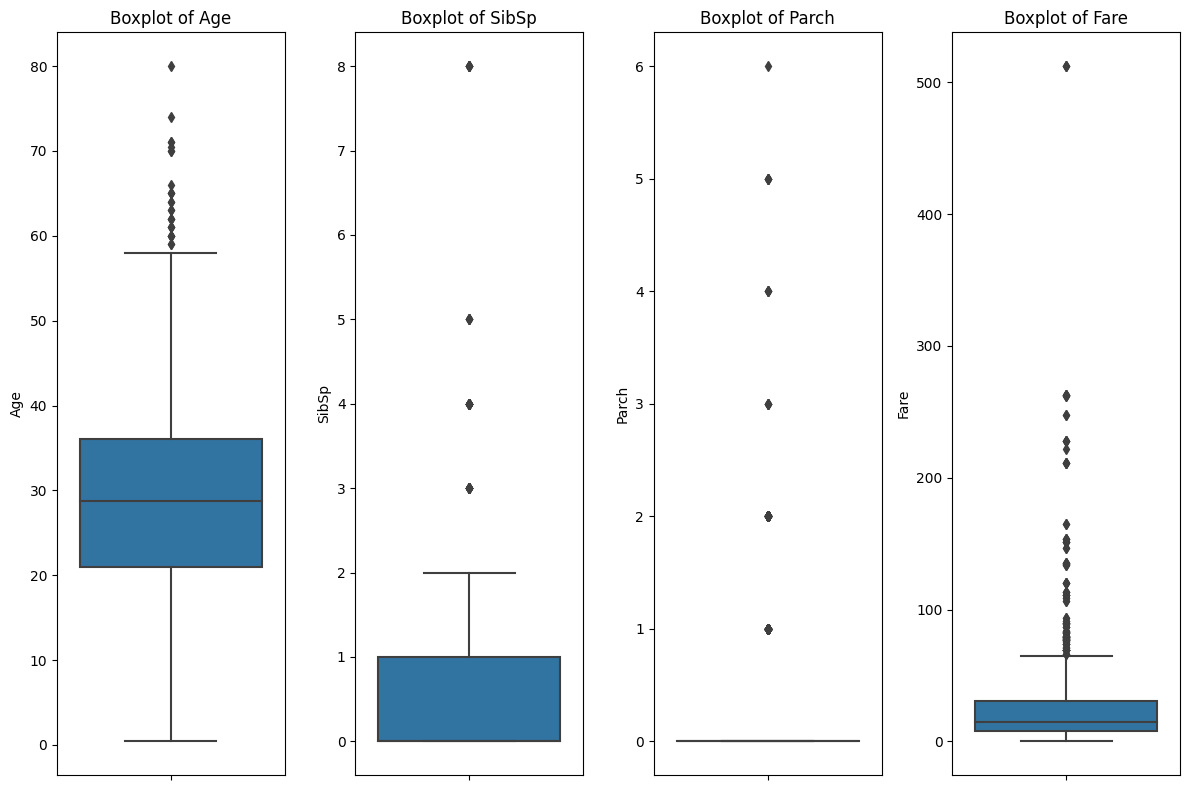

In [ ]:
#Se muestran las gráficas de caja del set de datos de train
cols = ['Age', 'SibSp', 'Parch', 'Fare']

plt.figure(figsize=(12, 8))
for i, column in enumerate(cols, 1):
    plt.subplot(1, 4, i)
    sns.boxplot(y=train[column])
    plt.ylabel(column)
    plt.title(f"Boxplot of {column}")

plt.tight_layout()
plt.show()

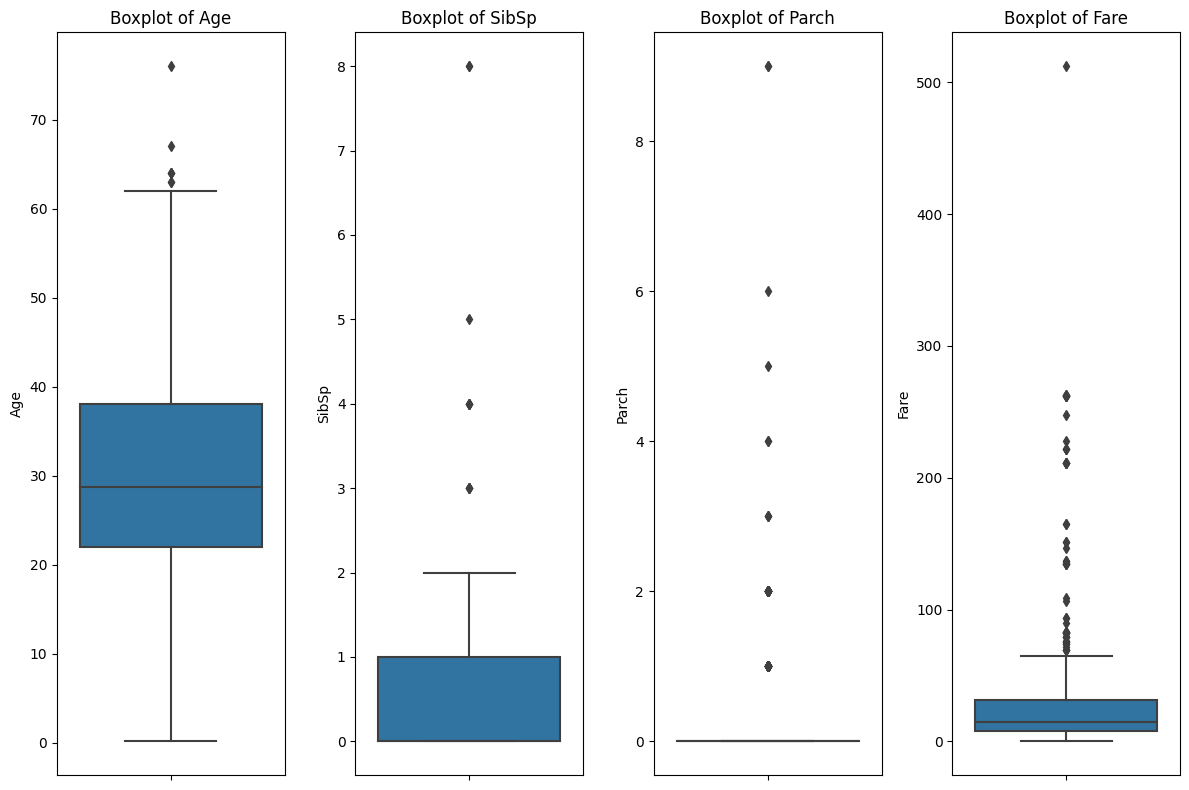

In [ ]:
#Se muestran las gráficas de caja del set de datos de test
cols = ['Age', 'SibSp', 'Parch', 'Fare']

plt.figure(figsize=(12, 8))
for i, column in enumerate(cols, 1):
    plt.subplot(1, 4, i)
    sns.boxplot(y=test[column])
    plt.ylabel(column)
    plt.title(f"Boxplot of {column}")

plt.tight_layout()
plt.show()

Finalmente nos encontramos con que algunas columnas tienen outlier. Entonces, nos podemos deshacer de ellos.

In [ ]:
#Eliminamos los registros con un Fare mas alto de 300, porque casi todos se encuentran en ese rango
train = train[train.Fare < 300]
test = test[test.Fare < 300]